In [65]:
import obspy
import instaseis
import pymc as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from obspy.taup import TauPyModel
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach,beachball
from theano import shared

%matplotlib inline

In [66]:
db = instaseis.open_db("./databases/20s_PREM_ANI_FORCES")
prem = TauPyModel('prem')

In [67]:
def forward_model(source,receiver,taup_model,t_start,t_end,phase='P',arr=None,return_stream=False):
    '''
    positional arguments
    source: instaseis source object
    receiver: instaseis receiver object
    taup_model: a TauPyModel object used to calculate travel times
    t_start: start time (in s) relative to phase arrival
    t_end: end time (in s) relative to phase arrival

    
    optional aguments
    phase: phase to window seismogram around (defaults to P)
    return_stream: if True, returns both the data vector and a three component (RTZ) obspy stream
    arr: an obspy taup arrival object. If none is provided, the travel time will be calculated.
    
    '''
    
    st = db.get_seismograms(source=source, receiver=receiver,components='RTZ',kind='displacement')
    if arr == None:
        phase_arrs = taup_model.get_travel_times_geo(source_depth_in_km=source.depth_in_m/1000.0, 
                                                     source_latitude_in_deg=source.latitude,
                                                     source_longitude_in_deg=source.longitude, 
                                                     receiver_latitude_in_deg=receiver.latitude,
                                                     receiver_longitude_in_deg=receiver.longitude,
                                                     phase_list=[phase])
        arr = phase_arrs[0]
        
    st_new = obspy.Stream()
    for tr in st:
        starttime = tr.stats.starttime + arr.time + t_start
        endtime = tr.stats.starttime + arr.time + t_end
        windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
        st_new += windowed_tr
        
    st = st_new
    st.sort()
    data_vector = np.hstack((st[0].data,st[1].data,st[2].data))
    
    if return_stream:
        return data_vector,st
    else:
        return data_vector

### Generate 'true' synthetic data

In [68]:
#define 'true' source parameters
normalize_factor = 1e17
m_rr_true = 4.710000e+17 / normalize_factor
m_tt_true = 3.810000e+15 / normalize_factor
m_pp_true = -4.740000e+17 / normalize_factor
m_rt_true = 3.990000e+16 / normalize_factor
m_rp_true = -8.050000e+16 / normalize_factor
m_tp_true = -1.230000e+17 / normalize_factor
lon_true = -77.93
lat_true = 37.91
depth_true = 12000.
mt_true = [m_rr_true,m_tt_true,m_pp_true,m_rt_true,m_rp_true,m_tp_true]

#define receiver parameters
rec_lon = -83.66
rec_lat = 42.3 

#make instaseis Source and Receiver objects
source_true = instaseis.Source(
    latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
    m_rr = m_rr_true,
    m_tt = m_tt_true,
    m_pp = m_pp_true,
    m_rt = m_rt_true,
    m_rp = m_rp_true,
    m_tp = m_tp_true,
    origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
print source_true
receiver = instaseis.Receiver(
    latitude=rec_lat, 
    longitude=rec_lon, 
    network="US", 
    station="AAM")

#calculate expected P arrival
phase_arrs = prem.get_travel_times_geo(source_depth_in_km=source_true.depth_in_m/1000.0, 
                                       source_latitude_in_deg=source_true.latitude,
                                       source_longitude_in_deg=source_true.longitude, 
                                       receiver_latitude_in_deg=receiver.latitude,
                                       receiver_longitude_in_deg=receiver.longitude,
                                       phase_list=['P'])
P_arr = phase_arrs[0]
print P_arr

#get synthetic data vector, and seismograms
data_true,st_true = forward_model(source_true,receiver,taup_model=prem,
                                  t_start=-20.,t_end=250.,arr=P_arr,return_stream=True)

data_true *= 1e21


Instaseis Source:
	Origin Time      : 2011-08-23T17:51:03.000000Z
	Longitude        :  -77.9 deg
	Latitude         :   37.9 deg
	Depth            : 1.2e+01 km km
	Moment Magnitude :   -5.60
	Scalar Moment    :   4.96e+00 Nm
	Mrr              :   4.71e+00 Nm
	Mtt              :   3.81e-02 Nm
	Mpp              :  -4.74e+00 Nm
	Mrt              :   3.99e-01 Nm
	Mrp              :  -8.05e-01 Nm
	Mtp              :  -1.23e+00 Nm

P phase arrival at 88.355 seconds


### Plot 'true' synthetic data

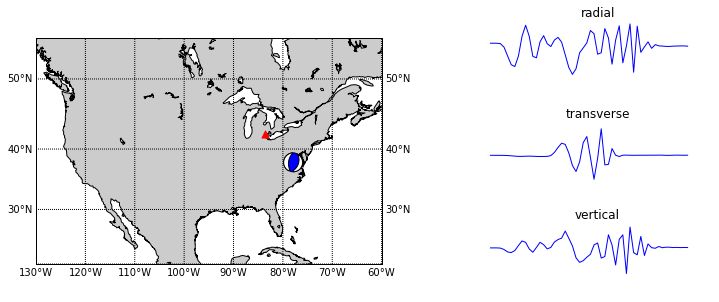

In [69]:
#plot map and 'true' (synthetic) data
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-130.,llcrnrlat=20.,urcrnrlon=-60.,urcrnrlat=55.,\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(np.arange(10,90,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,10),labels=[1,1,0,1])
x, y = m(lon_true, lat_true)
#ax = plt.gca()
b = beach(mt_true, xy=(x, y), width=400000, linewidth=1, alpha=1.0)
b.set_zorder(10)
ax.add_collection(b)
x, y = m(rec_lon, rec_lat)
ax.scatter(x,y,marker='^',color='r',s=50,zorder=99)

#plot_waveforms
#radial
ax_r=fig.add_axes([1.15,0.75,0.5,0.2])
ax_r.plot(st_true[0].data)
ax_r.set_title('radial')
ax_r.set_axis_off()
ax_t=fig.add_axes([1.15,0.4,0.5,0.2])
ax_t.plot(st_true[1].data)
ax_t.set_title('transverse')
ax_t.set_axis_off()
ax_z=fig.add_axes([1.15,0.05,0.5,0.2])
ax_z.plot(st_true[2].data)
ax_z.set_title('vertical')
ax_z.set_axis_off()
plt.show()
#st_true.plot()

### Define Monte Carlo model

In [70]:
def geosynth(m_rr=m_rr,m_tt=m_tt,mpp=m_pp,m_rt=m_rt,m_rp=m_rp):
    
    source_est = instaseis.Source(
                 latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
                 m_rr = float(m_rr),
                 m_tt = float(m_tt),
                 m_pp = float(m_pp),
                 m_rt = float(m_rt),
                 m_rp = float(m_rp),
                 m_tp = float(m_tp),
                 origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    
    receiver = instaseis.Receiver(
               latitude=rec_lat, 
               longitude=rec_lon, 
               network="US", 
               station="AAM")
    
    t_start = -20.0
    t_end = 250.0
    arr_time = 88.355
    
    st = db.get_seismograms(source=source_est, receiver=receiver,components='RTZ',kind='displacement')
    st_new = obspy.Stream()
    
    for tr in st:
        starttime = tr.stats.starttime + arr_time + t_start
        endtime = tr.stats.starttime + arr_time + t_end
        windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
        st_new += windowed_tr
        
    st = st_new
    st.sort()
    data_vector = np.hstack((st[0].data,st[1].data,st[2].data))
    print data_vector

    return data_vector

In [71]:
m_rr = pm.Uniform('m_rr',lower=-10,upper=10)
m_tt = pm.Uniform('m_tt',lower=-10,upper=10)
m_pp = pm.Uniform('m_pp',lower=-10,upper=10)
m_rt = pm.Uniform('m_rt',lower=-10,upper=10)
m_rp = pm.Uniform('m_rp',lower=-10,upper=10)
m_tp = pm.Uniform('m_tp',lower=-10,upper=10)

x = np.random.random(len(data_true))

t_start = -20.0
t_end = 250.0
arr_time = 88.355

#define data variance
sigma = 0.1
tau = np.power(sigma,-2)
#tau = 0.1


#define forward model
@pm.deterministic
def mu(m_rr=m_rr,m_tt=m_tt,m_pp=m_pp,m_rt=m_rt,m_rp=m_rp,m_tp=m_tp,x=x):
    
    source_est = instaseis.Source(
                 latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
                 m_rr = m_rr,
                 m_tt = m_tt,
                 m_pp = m_pp,
                 m_rt = m_rt,
                 m_rp = m_rp,
                 m_tp = m_tp,
                 origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    
    st = db.get_seismograms(source=source_est, receiver=receiver,components='RTZ',kind='displacement')
    st_new = obspy.Stream()
    for tr in st:
        starttime = tr.stats.starttime + arr_time + t_start
        endtime = tr.stats.starttime + arr_time + t_end
        windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
        st_new += windowed_tr
    st_new.sort()
    data_vector = np.hstack((st_new[0].data,st_new[1].data,st_new[2].data))
    data_vector *= 1e21
    
    misfit = np.linalg.norm(data_vector - data_true)
    pdm = np.exp(-0.5*(misfit/tau)**2)
    #if pdm >= 0.5:
    #    print pdm
    
    #plt.plot(data_vector)
    return data_vector

#tau = 1.0

#define likelyhood
y = pm.Normal('y', mu=mu, tau=tau, value=data_true, observed=True)
#y = pm.Normal('y', mu=mu, tau=tau, value=data_true)

#inference
#m = pm.Model([m_rr,m_tt,m_pp,m_rt,m_rp,m_tp,tau,y])
m = pm.Model([m_rr,m_tt,m_pp,m_rt,m_rp,m_tp,tau,y])
mc = pm.MCMC(m)
mc.sample(iter=50000,burn=10000)

 [-----------------100%-----------------] 50000 of 50000 complete in 1990.0 sec

Plotting m_pp
Plotting m_rt
Plotting m_rp
Plotting m_tt
Plotting m_tp
Plotting m_rr


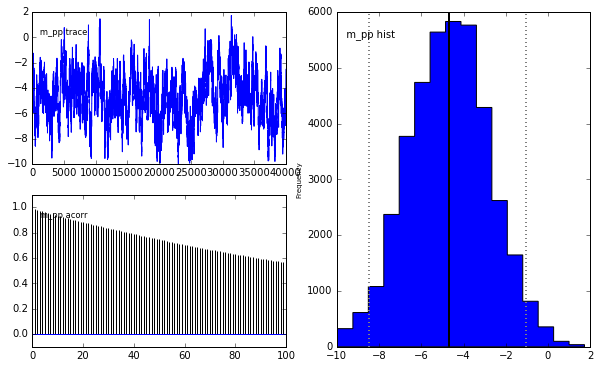

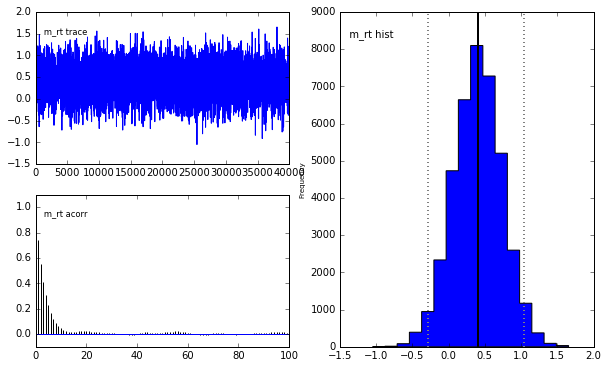

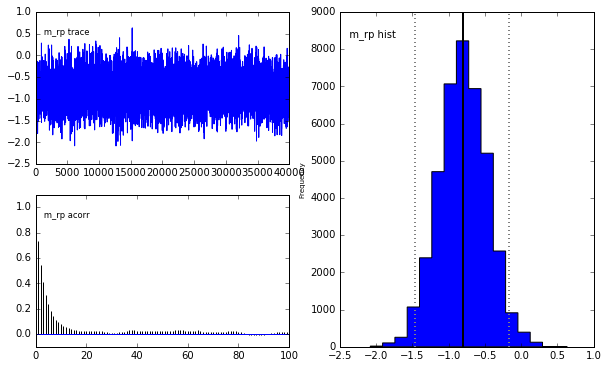

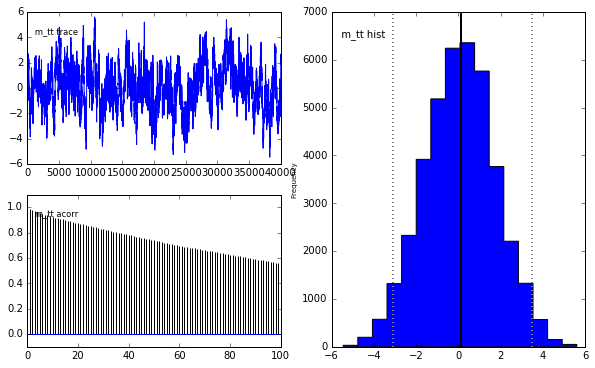

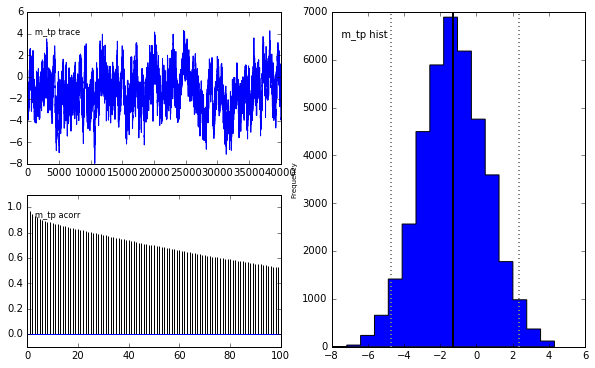

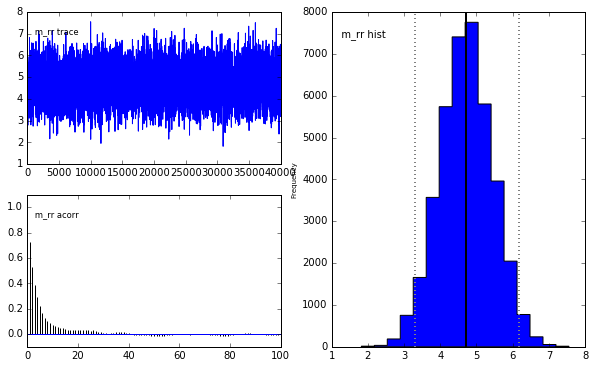

In [72]:
pm.Matplot.plot(mc)

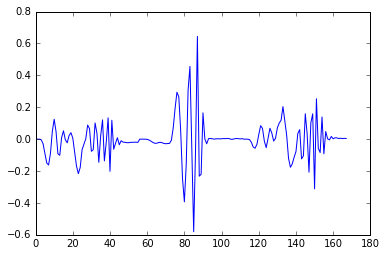

In [74]:
plt.plot(data_true)